In [92]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.batchmark = False
class_index = ['あいおいニッセイ同和損保フェニックスタワー',
               'ブリーゼタワー',
               'シティタワー西梅田',
               'グランフロント大阪 南館 タワーA',
               '梅田阪急ビル オフィスタワー',
               'ヒルトン大阪（吉本ビルディング）',
               '明治安田生命大阪梅田ビル',
               '大阪モード学園',
               'ノースゲートビルディング',
               'グランフロント大阪オーナーズタワー',
               '梅田スカイビル',
               'ヨドバシ梅田タワー']

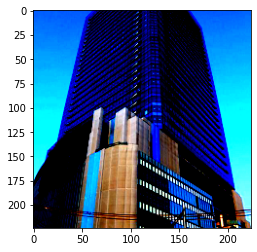

In [12]:
class BaseTransform():
    def __init__(self, size, mean, std):
        
        self.base_transform = {
            'train':
                transforms.Compose([
                transforms.RandomResizedCrop(size, scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
                ]),
            'val':
                transforms.Compose([
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
                ])
        }
        
    def __call__(self, img, phase='train'):
        return self.base_transform[phase](img)
        
image_file_path = 'data/granfront/000028.jpg'
img = Image.open(image_file_path)

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = BaseTransform(size, mean, std)
img_transformed = transform(img)

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [32]:
import os
import shutil

def shuffle_train_test(train, test):
    
    for path in glob.glob('./data/*'):
        
        trainpath = './data/train/'+path.split('/')[2]
        if not os.path.exists(trainpath):
            os.makedirs(trainpath)
            
        valpath = './data/val/'+path.split('/')[2]
        if not os.path.exists(valpath):
            os.makedirs(valpath)
            
        for j,image in enumerate(glob.glob('./data/'+path.split('/')[2]+'/*.jpg')):
            if j%5==0:
                shutil.copyfile(image, './data/val/'+path.split('/')[2]+'/'+image.split('/')[3])
            else:
                shutil.copyfile(image, './data/train/'+path.split('/')[2]+'/'+image.split('/')[3])
                
                                 
shuffle_train_test(10,2)

In [34]:
def make_data_path(phase='train'):
    rootpath = './data/'
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    path_list = []
    
    print(target_path)
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

train_list = make_data_path(phase='train')
val_list = make_data_path(phase='val')
print(train_list)
print(val_list)

./data/train/**/*.jpg
./data/val/**/*.jpg
['./data/train/meiji/000002.5.jpg', './data/train/meiji/train000082.jpg', './data/train/meiji/000011.6.jpg', './data/train/meiji/000010.6.jpg', './data/train/meiji/train000079.jpg', './data/train/meiji/000048.2.jpg', './data/train/meiji/000005.4.jpg', './data/train/meiji/val000064.jpg', './data/train/meiji/000031.5.jpg', './data/train/meiji/val000009.jpg', './data/train/meiji/000001.8.jpg', './data/train/meiji/000004.5.jpg', './data/train/meiji/000030.3.jpg', './data/train/meiji/000064.2.jpg', './data/train/meiji/000003.5.jpg', './data/train/hillton/000003.4.jpg', './data/train/hillton/000013.4.jpg', './data/train/hillton/000011.5.jpg', './data/train/hillton/000021.3.jpg', './data/train/hillton/000018.6.jpg', './data/train/hillton/000004.4.jpg', './data/train/hillton/val000062.jpg', './data/train/hillton/000016.5.jpg', './data/train/hillton/000026.4.jpg', './data/train/hillton/000005.3.jpg', './data/train/hillton/000006.5.jpg', './data/train/hi

In [63]:
class HymenopteraDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train'):
        
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == 'train':
            label = img_path.split('/')[3]
        elif self.phase == 'val':
            label = img_path.split('/')[3]
            
        
        label = class_index.index(label)
        #print(label)
        
        return img_transformed, label
    
train_dataset = HymenopteraDataset(file_list=train_list, transform=BaseTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(file_list=val_list, transform=BaseTransform(size, mean, std), phase='val')

index = 10
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
#print(train_dataset)

batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

dataloaders_dict = { 'train': train_dataloader, 'val': val_dataloader }

batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels)

torch.Size([3, 224, 224])
6
torch.Size([32, 3, 224, 224])
tensor([ 0, 10,  0,  0, 10, 10,  8, 10,  4,  6,  3, 10, 10,  4,  2, 10,  7,  2,
         3,  8,  9, 10,  4,  7,  5, 11, 10,  4,  2, 11,  9,  9])


In [75]:
class MultiClassifier():
    
    def __init__(self):
        use_pretrained = True
        self.net = models.vgg16(pretrained=use_pretrained)

        self.net.classifier[6] = nn.Linear(in_features=4096, out_features=len(class_index))
        print(net)
        self.net.train()

        print('configuration network!!')

        criterion = nn.CrossEntropyLoss()

        params_to_update = []

        update_params_names = ['classifier.6.weight', 'classifier.6.bias']

        for name, param in self.net.named_parameters():
            if name in update_params_names:
                param.require_names_grad = True
                params_to_update.append(param)
                print(name)
            else:
                params.requires_grad = False


        print('---------')
        print(params_to_update)

        optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [72]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('usein device: ', device)
    
    net.to(device)
    
    torch.backends.cuidnn.benchmark = True
    
    for epoch in range(num_epochs):
        print('Epochs {}/{}'.format(epoch+1, num_epochs))
        print('------------')
        
        for phase in ['train','val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if (epoch == 0) and (phase == 'train'):
                continue
            
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
num_epochs = 20
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)



  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 1/20
------------


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 1.9399 Acc: 0.3239
Epochs 2/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 1.9511 Acc: 0.3793


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 1.5979 Acc: 0.5493
Epochs 3/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 1.5943 Acc: 0.4866


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 1.3562 Acc: 0.5915
Epochs 4/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 1.3186 Acc: 0.6743


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 1.1666 Acc: 0.7465
Epochs 5/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 1.2023 Acc: 0.6705


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 1.0834 Acc: 0.7606
Epochs 6/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 1.0361 Acc: 0.6897


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 1.0017 Acc: 0.7606
Epochs 7/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.9666 Acc: 0.7548


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.9098 Acc: 0.8028
Epochs 8/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.8947 Acc: 0.7663


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.8614 Acc: 0.7746
Epochs 9/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.8224 Acc: 0.7893


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.8227 Acc: 0.8169
Epochs 10/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.8002 Acc: 0.7931


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.8067 Acc: 0.7887
Epochs 11/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.7691 Acc: 0.8123


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.7250 Acc: 0.8169
Epochs 12/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.7049 Acc: 0.8046


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.7364 Acc: 0.8310
Epochs 13/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6546 Acc: 0.8736


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6714 Acc: 0.8310
Epochs 14/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6383 Acc: 0.8506


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6381 Acc: 0.8310
Epochs 15/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6102 Acc: 0.8429


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6440 Acc: 0.8451
Epochs 16/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5980 Acc: 0.8429


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6248 Acc: 0.8028
Epochs 17/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6113 Acc: 0.8276


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5994 Acc: 0.8451
Epochs 18/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.6056 Acc: 0.8314


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5882 Acc: 0.8310
Epochs 19/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5739 Acc: 0.8582


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5978 Acc: 0.8310
Epochs 20/20
------------


  0%|          | 0/3 [00:00<?, ?it/s]

train Loss: 0.5145 Acc: 0.8812


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

val Loss: 0.5860 Acc: 0.8169


In [73]:
save_path = './weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

In [76]:
load_path = './weights_fine_tuning.pth'
load_weights = torch.load(load_path)
#net.load_state_dict(load_weights)

#model = MultiClassifier()
net.load_state_dict(torch.load(load_path, map_location={'cuda:0': 'cpu'}))
net.eval()

In [88]:
class Predictor():
    
    def __init__(self):
        self.class_index = class_index
        
    def predict_max(self, out):
        maxid = np.argmax(out.detach().numpy())
        predict_label_name = self.class_index[maxid]
        
        return predict_label_name

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


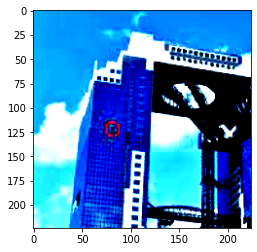

このビルは「梅田スカイビル」です


In [98]:
image_path = './data/images.jpg'
img = Image.open(image_path)

transform = BaseTransform(size, mean, std)
img_transformed = transform(img)
plt.imshow(img_transformed.numpy().transpose((1,2,0)))
plt.show()

inputs = img_transformed.unsqueeze_(0)

out = net(inputs)

predictor = Predictor()
result = predictor.predict_max(out)

print('このビルは「{}」です'.format(result))